In [1]:
import time
import spo
import torch
from matplotlib import pyplot as plt
import numpy as np
from tqdm import tqdm
torch.manual_seed(135)

## Init Data

In [2]:
# generate data for grid network (features and costs)
m = 20 # number of nodes
n = 1000 # number of data
p = 10 # size of feature
deg = 4 # polynomial degree
x, c = spo.data.tsp.genData(n+1000, p, m, deg=deg, noise_width=0)

## Optimization model

In [3]:
tsp_model = spo.model.tspModel(m)


--------------------------------------------
--------------------------------------------

Academic license - for non-commercial use only - expires 2021-08-20
Using license file C:\Users\Apocrypse\gurobi.lic


In [4]:
# solve
tsp_model.setObj(c[0])
sol, obj = tsp_model.solve()
print('Obj: {}'.format(obj))
tour = tsp_model.getTour(sol)
print(' -> '.join(map(str, tour)))

Obj: 105.82300000000001
0 -> 2 -> 14 -> 6 -> 18 -> 5 -> 10 -> 9 -> 1 -> 4 -> 7 -> 19 -> 11 -> 8 -> 12 -> 3 -> 17 -> 15 -> 16 -> 13 -> 0


## Data Loader

In [5]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

In [6]:
# data split
x_train, x_test, c_train, c_test = train_test_split(x, c, test_size=1000, random_state=246)

In [7]:
# get training data set
tsp_dataset_train = spo.data.dataset.optDataset(tsp_model, x_train, c_train)

Optimizing for optDataset...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [00:26<00:00, 37.86it/s]


In [8]:
# get test data set
tsp_dataset_test = spo.data.dataset.optDataset(tsp_model, x_test, c_test)

Optimizing for optDataset...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [00:21<00:00, 46.20it/s]


In [9]:
# get data loader
batch_size = 32
tsp_loader_train = DataLoader(tsp_dataset_train, batch_size=batch_size, shuffle=True)
tsp_loader_test = DataLoader(tsp_dataset_test, batch_size=batch_size, shuffle=False)

In [10]:
for i, data in enumerate(tsp_loader_train):
    x, c, w, z = data
    break

In [11]:
x.shape

torch.Size([32, 10])

In [12]:
c.shape

torch.Size([32, 190])

In [13]:
w.shape

torch.Size([32, 190])

In [14]:
z.shape

torch.Size([32, 1])

## Linear Regression from Scikit-Lear 

In [15]:
from sklearn.linear_model import LinearRegression

In [16]:
# prediction model
reg = LinearRegression()

## Two-Stage 

In [17]:
# build model
twostage_model = spo.twostage.sklearnPred(reg, tsp_model)

In [18]:
# training
twostage_model.fit(tsp_dataset_train.x, tsp_dataset_train.c)

In [19]:
# prediction
c_test_pred = twostage_model.predict(tsp_dataset_test.x)

In [20]:
# evaluate
truespo = 0
unambspo = 0
for i in tqdm(range(1000)):
    c_pred_i = c_test_pred[i]
    c_true_i = tsp_dataset_test.c[i]
    z_true_i = tsp_dataset_test.z[i,0]
    truespo += spo.eval.calTrueSPO(tsp_model, c_pred_i, c_true_i, z_true_i)
    unambspo += spo.eval.calUnambSPO(tsp_model, c_pred_i, c_true_i, z_true_i)
time.sleep(1)
print('Normalized true SPO Loss: {:.2f}%'.format(truespo / abs(tsp_dataset_test.z.sum()) * 100))
print('Normalized unambiguous SPO Loss: {:.2f}%'.format(unambspo / abs(tsp_dataset_test.z.sum()) * 100))

100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [01:28<00:00, 11.35it/s]


Normalized true SPO Loss: 8.25%
Normalized unambiguous SPO Loss: 8.25%


In [21]:
# compare solutions
for i, data in enumerate(tsp_loader_test):
    # load data
    x, c, w, z = data
    # cuda
    if torch.cuda.is_available():
        x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
    # convert to numpy
    x = x.to('cpu').detach().numpy()
    c = c.to('cpu').detach().numpy()
    w = w.to('cpu').detach().numpy()
    z = z.to('cpu').detach().numpy()
    # predict
    cp = twostage_model.predict(x)
    for j in range(min(10, batch_size)):
        print('Sample {}:'.format(j))
        print('    True cost:', ', '.join(['{:.2f}'.format(cost) for cost in c[j]]))
        print('    Pred cost:', ', '.join(['{:.2f}'.format(cost) for cost in cp[j]]))
        # solve cost from prediction
        tsp_model.setObj(cp[j])
        wpj, _ = tsp_model.solve()
        zpj = np.dot(c[j], wpj)
        tour = tsp_model.getTour(w[j])
        print('    True sol: ' + ' -> '.join(map(str, tour)) + ', True obj: {:.2f}'.format(z[j,0]))
        tour = tsp_model.getTour(wpj)
        print('    True sol: ' + ' -> '.join(map(str, tour)) + ', True obj: {:.2f}'.format(zpj))
        print()
    break

Sample 0:
    True cost: 13.25, 4.86, 8.45, 10.37, 11.59, 7.92, 11.79, 9.19, 31.81, 14.29, 15.88, 18.52, 4.62, 9.18, 12.49, 3.04, 5.85, 13.22, 5.49, 19.30, 9.96, 3.84, 9.55, 10.27, 10.12, 13.34, 3.58, 19.97, 12.15, 10.98, 14.39, 8.80, 6.37, 9.62, 5.41, 24.63, 6.22, 10.21, 16.54, 5.43, 4.92, 15.74, 11.16, 11.72, 8.56, 4.76, 9.56, 5.97, 6.99, 26.69, 12.31, 8.39, 8.14, 7.51, 19.35, 35.81, 13.44, 15.61, 15.96, 18.10, 12.31, 7.08, 8.60, 8.21, 12.19, 8.99, 6.85, 5.14, 15.12, 25.72, 19.09, 12.86, 8.26, 15.34, 4.74, 8.27, 15.21, 11.81, 11.34, 8.86, 13.00, 12.24, 9.96, 11.69, 7.03, 3.55, 7.19, 11.21, 9.27, 5.41, 8.63, 22.09, 8.56, 6.08, 14.82, 8.14, 12.44, 6.30, 6.68, 7.42, 18.44, 13.47, 3.02, 9.94, 11.70, 6.12, 5.52, 6.81, 13.11, 22.28, 3.60, 8.69, 20.46, 6.85, 8.35, 11.98, 14.46, 10.66, 17.24, 13.49, 17.29, 10.72, 8.30, 19.77, 14.82, 10.57, 7.58, 3.31, 8.00, 9.19, 7.16, 8.48, 5.51, 13.26, 8.63, 7.08, 11.09, 20.63, 10.96, 16.02, 5.98, 6.98, 7.15, 9.08, 6.95, 7.20, 11.16, 7.63, 9.35, 6.53, 3.10

    True sol: 0 -> 8 -> 3 -> 12 -> 15 -> 17 -> 13 -> 11 -> 14 -> 19 -> 9 -> 4 -> 1 -> 7 -> 6 -> 18 -> 10 -> 5 -> 2 -> 16 -> 0, True obj: 104.42
    True sol: 0 -> 8 -> 12 -> 3 -> 15 -> 17 -> 13 -> 11 -> 7 -> 1 -> 4 -> 9 -> 19 -> 14 -> 5 -> 10 -> 18 -> 6 -> 2 -> 16 -> 0, True obj: 107.88

Sample 6:
    True cost: 8.61, 4.15, 14.70, 13.16, 4.78, 11.97, 20.07, 7.39, 9.27, 5.90, 1.41, 7.79, 7.34, 2.62, 9.75, 11.16, 6.97, 13.32, 31.69, 11.46, 21.37, 5.16, 10.23, 15.43, 10.85, 49.61, 3.65, 7.58, 7.97, 12.28, 7.95, 11.88, 15.84, 8.23, 8.16, 13.23, 30.42, 15.82, 16.29, 5.57, 11.42, 13.58, 15.53, 19.91, 10.94, 4.44, 19.21, 13.72, 16.99, 8.72, 6.27, 16.44, 16.61, 14.87, 6.80, 17.41, 11.89, 50.16, 7.09, 7.55, 7.64, 9.51, 8.56, 8.03, 9.23, 7.16, 6.93, 5.00, 12.24, 6.40, 11.62, 18.89, 4.90, 12.18, 2.42, 10.91, 16.85, 11.65, 9.59, 11.74, 9.30, 8.00, 16.16, 12.78, 6.20, 4.92, 12.41, 20.38, 11.73, 4.57, 8.32, 11.47, 12.13, 3.71, 6.92, 9.45, 16.81, 3.75, 7.45, 11.86, 10.09, 10.24, 9.97, 4.99, 38.20, 8.

## Linear Regression from PyTorch 

In [22]:
from torch import nn

In [23]:
# build linear model
class LinearRegression(nn.Module):
    
    def __init__(self):
        super(LinearRegression, self).__init__()
        self.linear = nn.Linear(p, m*(m-1)//2)
    
    def forward(self, x):
        out = self.linear(x)
        return out

## SPO+ 

In [24]:
# init model
reg = LinearRegression()
# cuda
if torch.cuda.is_available():
    reg = reg.cuda()

In [25]:
# set optimizer
optimizer = torch.optim.Adam(reg.parameters(), lr=1e-2)

In [26]:
# init SPO+ loss
criterion = spo.func.SPOPlus(tsp_model, processes=1)

Num of cores: 1


In [27]:
# train model
num_epochs = 300
reg.train()
loss_log = []
loss_log_truespo = []
loss_log_unambspo = []
for epoch in range(num_epochs):
    # load data
    for i, data in enumerate(tsp_loader_train):
        x, c, w, z = data
        # cuda
        if torch.cuda.is_available():
            x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
        # forward pass
        cp = reg(x)
        loss = criterion.apply(cp, c, w, z).mean()
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    loss_log.append(loss.item())
    if (epoch + 1) % 10 == 0:
        # true SPO
        trueloss = spo.eval.trueSPO(reg, tsp_model, tsp_loader_test)
        loss_log_truespo.append(trueloss)
        # unambiguous SPO 
        unambloss = spo.eval.unambSPO(reg, tsp_model, tsp_loader_test)
        loss_log_unambspo.append(unambloss)
        print('Epoch {:3}, Loss: {:9.4f}, True SPO Loss: {:7.4f}%, Unambiguous SPO Loss: {:7.4f}%'. \
              format(epoch+1, loss.item(), trueloss*100, unambloss*100))

Epoch  10, Loss:   92.9812, True SPO Loss: 12.3811%, Unambiguous SPO Loss: 12.3811%
Epoch  20, Loss:   35.9819, True SPO Loss:  6.7041%, Unambiguous SPO Loss:  6.7041%
Epoch  30, Loss:   39.6606, True SPO Loss:  4.5786%, Unambiguous SPO Loss:  4.5786%
Epoch  40, Loss:   15.5230, True SPO Loss:  3.7412%, Unambiguous SPO Loss:  3.7412%
Epoch  50, Loss:   41.8503, True SPO Loss:  3.2250%, Unambiguous SPO Loss:  3.2250%
Epoch  60, Loss:   12.6411, True SPO Loss:  2.7875%, Unambiguous SPO Loss:  2.7875%
Epoch  70, Loss:   27.1929, True SPO Loss:  2.6595%, Unambiguous SPO Loss:  2.6595%
Epoch  80, Loss:   15.0035, True SPO Loss:  2.4439%, Unambiguous SPO Loss:  2.4439%
Epoch  90, Loss:   17.7909, True SPO Loss:  2.3189%, Unambiguous SPO Loss:  2.3189%
Epoch 100, Loss:   11.0727, True SPO Loss:  2.1932%, Unambiguous SPO Loss:  2.1932%
Epoch 110, Loss:   16.4733, True SPO Loss:  1.9589%, Unambiguous SPO Loss:  1.9589%
Epoch 120, Loss:   13.6751, True SPO Loss:  1.8803%, Unambiguous SPO Loss:  

The history saving thread hit an unexpected error (OperationalError('database or disk is full')).History will not be written to the database.


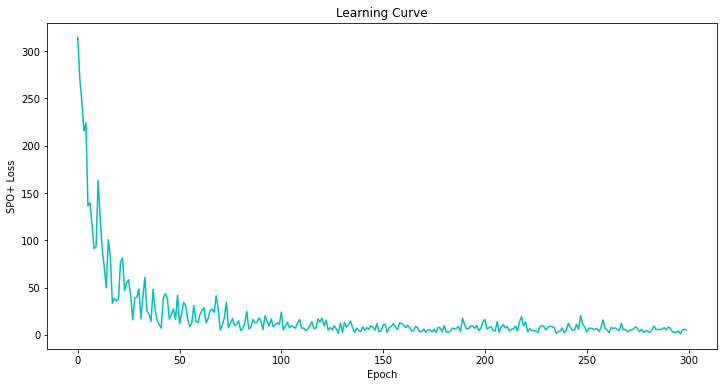

In [28]:
# draw plot
plt.figure(figsize=(12, 6))
plt.plot(loss_log, color='c')
plt.xlabel('Epoch')
plt.ylabel('SPO+ Loss')
plt.title('Learning Curve')
plt.show()

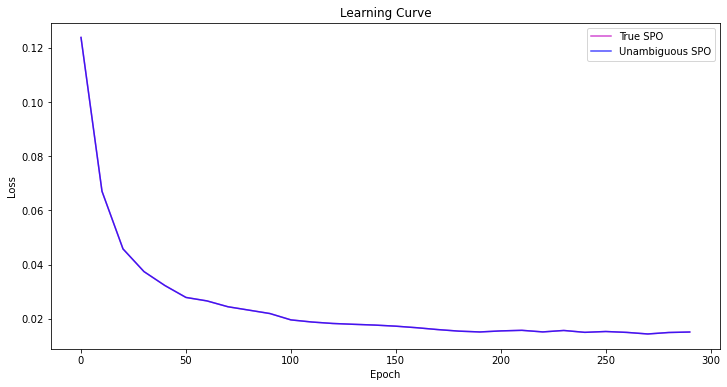

In [29]:
# draw plot
plt.figure(figsize=(12, 6))
plt.plot(range(0, num_epochs, 10), loss_log_truespo, color='m', alpha=0.7, label='True SPO')
plt.plot(range(0, num_epochs, 10), loss_log_unambspo, color='b', alpha=0.7, label='Unambiguous SPO')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Learning Curve')
plt.legend()
plt.show()

In [30]:
# evaluate
spoloss = spo.eval.trueSPO(reg, tsp_model, tsp_loader_test)
print('Normalized true SPO Loss: {:.2f}%'.format(spoloss * 100))
spoloss = spo.eval.unambSPO(reg, tsp_model, tsp_loader_test)
print('Normalized unambiguous SPO Loss: {:.2f}%'.format(spoloss * 100))

Normalized true SPO Loss: 1.51%
Normalized unambiguous SPO Loss: 1.51%


In [31]:
reg.eval()
# compare solutions
for i, data in enumerate(tsp_loader_test):
    # load data
    x, c, w, z = data
    # cuda
    if torch.cuda.is_available():
        x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
    # predict
    cp = reg(x)
    # convert to numpy
    x = x.to('cpu').detach().numpy()
    c = c.to('cpu').detach().numpy()
    w = w.to('cpu').detach().numpy()
    z = z.to('cpu').detach().numpy()
    for j in range(min(10, batch_size)):
        print('Sample {}:'.format(j))
        print('    True cost:', ', '.join(['{:.2f}'.format(cost) for cost in c[j]]))
        print('    Pred cost:', ', '.join(['{:.2f}'.format(cost) for cost in cp[j]]))
        # solve cost from prediction
        tsp_model.setObj(cp[j])
        wpj, _ = tsp_model.solve()
        zpj = np.dot(c[j], wpj)
        tour = tsp_model.getTour(w[j])
        print('    True sol: ' + ' -> '.join(map(str, tour)) + ', True obj: {:.2f}'.format(z[j,0]))
        tour = tsp_model.getTour(wpj)
        print('    True sol: ' + ' -> '.join(map(str, tour)) + ', True obj: {:.2f}'.format(zpj))
        print()
    break

Sample 0:
    True cost: 13.25, 4.86, 8.45, 10.37, 11.59, 7.92, 11.79, 9.19, 31.81, 14.29, 15.88, 18.52, 4.62, 9.18, 12.49, 3.04, 5.85, 13.22, 5.49, 19.30, 9.96, 3.84, 9.55, 10.27, 10.12, 13.34, 3.58, 19.97, 12.15, 10.98, 14.39, 8.80, 6.37, 9.62, 5.41, 24.63, 6.22, 10.21, 16.54, 5.43, 4.92, 15.74, 11.16, 11.72, 8.56, 4.76, 9.56, 5.97, 6.99, 26.69, 12.31, 8.39, 8.14, 7.51, 19.35, 35.81, 13.44, 15.61, 15.96, 18.10, 12.31, 7.08, 8.60, 8.21, 12.19, 8.99, 6.85, 5.14, 15.12, 25.72, 19.09, 12.86, 8.26, 15.34, 4.74, 8.27, 15.21, 11.81, 11.34, 8.86, 13.00, 12.24, 9.96, 11.69, 7.03, 3.55, 7.19, 11.21, 9.27, 5.41, 8.63, 22.09, 8.56, 6.08, 14.82, 8.14, 12.44, 6.30, 6.68, 7.42, 18.44, 13.47, 3.02, 9.94, 11.70, 6.12, 5.52, 6.81, 13.11, 22.28, 3.60, 8.69, 20.46, 6.85, 8.35, 11.98, 14.46, 10.66, 17.24, 13.49, 17.29, 10.72, 8.30, 19.77, 14.82, 10.57, 7.58, 3.31, 8.00, 9.19, 7.16, 8.48, 5.51, 13.26, 8.63, 7.08, 11.09, 20.63, 10.96, 16.02, 5.98, 6.98, 7.15, 9.08, 6.95, 7.20, 11.16, 7.63, 9.35, 6.53, 3.10

    Pred cost: 16.52, -16.84, -0.89, 18.28, -5.68, 4.81, 6.28, 2.56, 16.71, -5.20, 2.47, 7.58, 1.97, 5.90, -3.46, -5.34, 11.37, -3.97, -9.34, 8.95, 4.02, -5.91, 10.64, 9.95, -4.03, 12.85, -11.93, 11.79, -0.34, 5.45, 6.03, 2.49, -15.69, 8.55, -8.98, 15.66, -4.44, 5.77, 15.32, 10.16, -4.52, 17.26, 0.23, 14.86, 1.01, -3.85, -0.33, -11.35, -6.04, 9.08, 3.54, 3.66, -7.61, 1.33, -9.84, 22.89, 10.97, 12.97, 0.85, -7.35, 3.54, -2.55, -6.83, -10.19, 6.02, -6.23, 6.76, -9.84, 16.24, 6.02, 13.44, 6.37, -19.84, 18.93, -4.87, 9.23, 2.76, 12.75, 11.39, 6.05, -1.34, 6.49, 2.90, 14.98, -5.49, -22.25, 3.23, 9.61, 5.56, -4.54, 3.13, 24.79, -0.58, -8.08, 24.07, 1.46, 7.25, -14.43, 3.10, 6.69, 26.59, 6.83, -9.97, 8.63, 8.66, 1.88, -6.63, 17.28, 7.36, 20.42, -12.72, 6.42, 7.63, -11.51, 6.70, -0.50, 10.87, -2.10, 1.66, 5.59, 12.20, 11.28, 4.00, 3.95, 7.87, 9.51, -12.08, -15.89, -15.70, 2.92, 5.41, 6.18, 2.95, 14.69, 9.58, 1.79, 3.88, 23.68, -3.71, 5.25, -0.22, -0.66, 3.81, 3.43, 3.44, -5.17, 6.37, 5.61, -0.

    Pred cost: 15.95, -0.24, 4.37, 17.75, -4.18, -4.01, 2.95, 1.41, 14.32, 3.05, -18.02, -3.90, -1.32, -9.33, -2.89, -0.97, 17.48, -5.86, 7.34, 5.25, -2.47, -8.29, 14.95, 11.56, -3.00, 12.94, -4.69, -5.07, 2.07, -1.01, -0.73, 4.22, 3.25, -1.45, -0.57, 13.09, -2.19, 7.27, 14.24, -7.51, -3.00, 17.55, -9.71, 11.99, -11.03, -8.77, -3.98, -0.80, -0.05, -6.69, -4.40, 4.25, -1.50, 5.97, -1.03, 15.13, 9.19, 10.03, 0.06, -4.19, -1.65, 4.25, -3.73, 3.15, 0.30, 0.38, 0.60, -10.76, 12.86, 0.54, 11.99, 16.43, -14.57, 7.89, -14.20, 2.77, 12.39, 11.22, 14.04, 6.11, 5.73, 6.62, 1.10, 14.19, 6.14, -12.27, 8.32, 11.51, 9.95, 4.01, 7.75, 20.21, -0.03, -0.60, 15.08, 6.09, 8.08, -16.39, 5.47, -2.21, -5.43, 15.23, 4.63, -3.35, 12.81, 0.16, -10.86, 3.87, -8.25, -0.95, 2.01, 0.69, 9.44, -7.75, -10.73, 15.20, 10.60, 9.56, 11.91, 3.46, 6.18, 8.57, 0.65, -10.51, 14.21, 7.90, 6.21, -13.15, -3.06, 5.55, -3.62, 0.66, 1.88, 13.09, 9.08, 0.21, 9.81, 14.14, 6.96, -1.22, 2.04, 0.42, -2.77, 6.78, 4.29, 8.93, 9.03, 0.19,